# Chapter 8. 차원축소

In [1]:
import sys
from packaging import version
import sklearn

In [2]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

import sys
# 코랩의 경우 나눔 폰트를 설치합니다.
if 'google.colab' in sys.modules:
    !sudo apt-get -qq -y install fonts-nanum
    import matplotlib.font_manager as fm
    font_files = fm.findSystemFonts(fontpaths=['/usr/share/fonts/truetype/nanum'])
    for fpath in font_files:
        fm.fontManager.addfont(fpath)

# 나눔 폰트를 사용합니다.
import matplotlib 

matplotlib.rc('font', family='NanumBarunGothic')
matplotlib.rcParams['axes.unicode_minus'] = False

In [3]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "dim_reduction"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

## 8.3 PCA

작은 3D 데이터 집합을 생성해봅니다. 타원형이고 3D 공간에서 회전하며 점드링 고르지 않게 분포되어 있고 노이즈가 상당히 많은 데이터입니다.ㅏ 

In [4]:
import numpy as np
from scipy.spatial.transform import Rotation

m = 60
X = np.zeros((m, 3))  # 3D 데이터 초기화
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi  # 고르지 않은 분포
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5  # 타원형
X += 0.28 * np.random.randn(m, 3)  # 노이즈 추가
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]  # 약간 이동

findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.
findfont: Font family ['NanumBarunGothic'] not found. Falling back to DejaVu Sans.


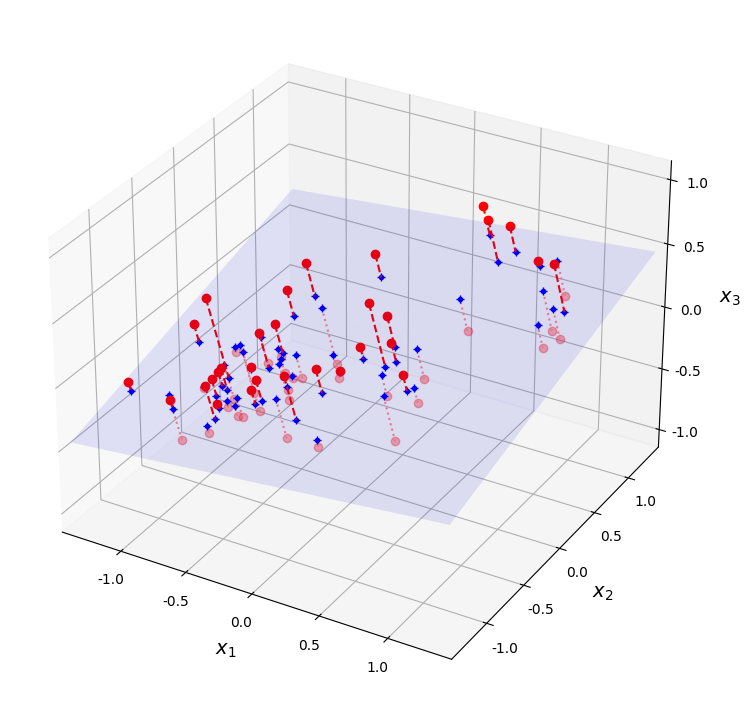

In [5]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)  # 2D로 축소된 데이터셋
X3D_inv = pca.inverse_transform(X2D)  # 투영된 샘플의 3D 위치
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)

axes = [-1.4, 1.4, -1.4, 1.4, -1.1, 1.1]
x1, x2 = np.meshgrid(np.linspace(axes[0], axes[1], 10),
                     np.linspace(axes[2], axes[3], 10))
w1, w2 = np.linalg.solve(Vt[:2, :2], Vt[:2, 2])  # 투영 평면의 계수
z = w1 * (x1 - pca.mean_[0]) + w2 * (x2 - pca.mean_[1]) - pca.mean_[2]  # 평면
X3D_above = X[X[:, 2] >= X3D_inv[:, 2]]  # 평면 위의 샘플
X3D_below = X[X[:, 2] < X3D_inv[:, 2]]  # 평면 아래 샘플

fig = plt.figure(figsize=(9, 9))
ax = fig.add_subplot(111, projection="3d")

# 평면 아래에 샘플과 투영선을 먼저 그립니다.
ax.plot(X3D_below[:, 0], X3D_below[:, 1], X3D_below[:, 2], "ro", alpha=0.3)
for i in range(m):
    if X[i, 2] < X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], ":", color="#F88")

ax.plot_surface(x1, x2, z, alpha=0.1, color="b")  # 투영 평면
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b+")  # 투영 샘플
ax.plot(X3D_inv[:, 0], X3D_inv[:, 1], X3D_inv[:, 2], "b.")

# 이제 평면 위 샘플과 투영선을 그립니다.
for i in range(m):
    if X[i, 2] >= X3D_inv[i, 2]:
        ax.plot([X[i][0], X3D_inv[i][0]],
                [X[i][1], X3D_inv[i][1]],
                [X[i][2], X3D_inv[i][2]], "r--")

ax.plot(X3D_above[:, 0], X3D_above[:, 1], X3D_above[:, 2], "ro")

def set_xyz_axes(ax, axes):
    ax.xaxis.set_rotate_label(False)
    ax.yaxis.set_rotate_label(False)
    ax.zaxis.set_rotate_label(False)
    ax.set_xlabel("$x_1$", labelpad=8, rotation=0)
    ax.set_ylabel("$x_2$", labelpad=8, rotation=0)
    ax.set_zlabel("$x_3$", labelpad=8, rotation=0)
    ax.set_xlim(axes[0:2])
    ax.set_ylim(axes[2:4])
    ax.set_zlim(axes[4:6])

set_xyz_axes(ax, axes)
ax.set_zticks([-1, -0.5, 0, 0.5, 1])

save_fig("dataset_3d_plot", tight_layout=False)
plt.show()


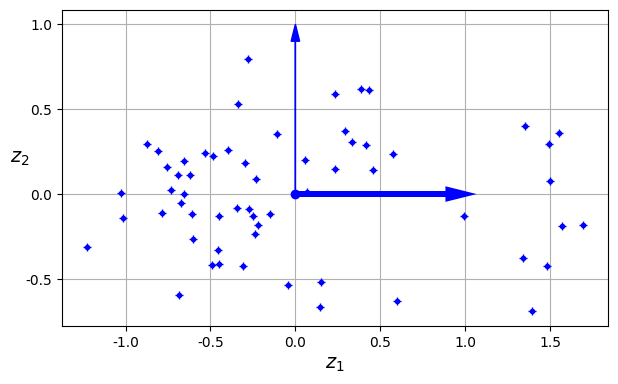

In [6]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, aspect='equal')
ax.plot(X2D[:, 0], X2D[:, 1], "b+")
ax.plot(X2D[:, 0], X2D[:, 1], "b.")
ax.plot([0], [0], "bo")
ax.arrow(0, 0, 1, 0, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=4)
ax.arrow(0, 0, 0, 1, head_width=0.05, length_includes_head=True,
         head_length=0.1, fc='b', ec='b', linewidth=1)
ax.set_xlabel("$z_1$")
ax.set_yticks([-0.5, 0, 0.5, 1])
ax.set_ylabel("$z_2$", rotation=0)
ax.set_axisbelow(True)
ax.grid(True)
save_fig("dataset_2d_plot")

In [7]:
# 스위스롤 데이터
from sklearn.datasets import make_swiss_roll

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)


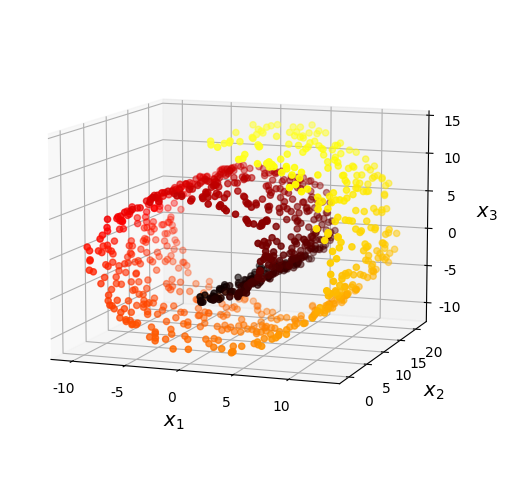

In [8]:
from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')

ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
set_xyz_axes(ax, axes)
save_fig("swiss_roll_plot")
plt.show()

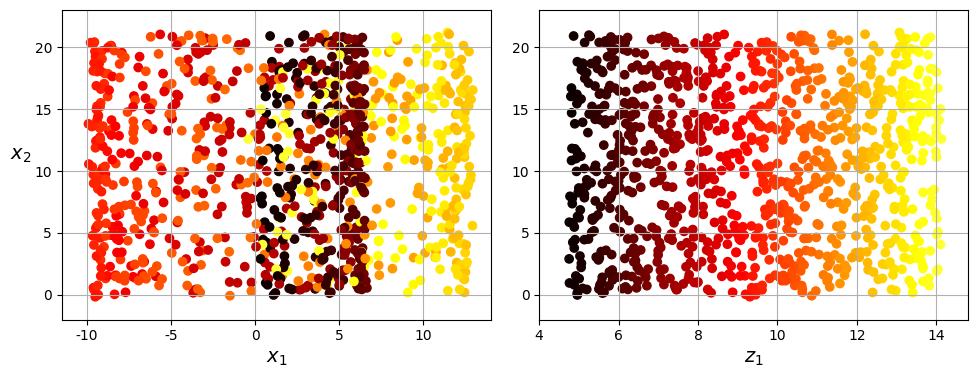

In [9]:
plt.figure(figsize=(10, 4))

plt.subplot(121)
plt.scatter(X_swiss[:, 0], X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis(axes[:4])
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", labelpad=10, rotation=0)
plt.grid(True)

plt.subplot(122)
plt.scatter(t, X_swiss[:, 1], c=t, cmap=darker_hot)
plt.axis([4, 14.8, axes[2], axes[3]])
plt.xlabel("$z_1$")
plt.grid(True)

save_fig("squished_swiss_roll_plot")
plt.show()

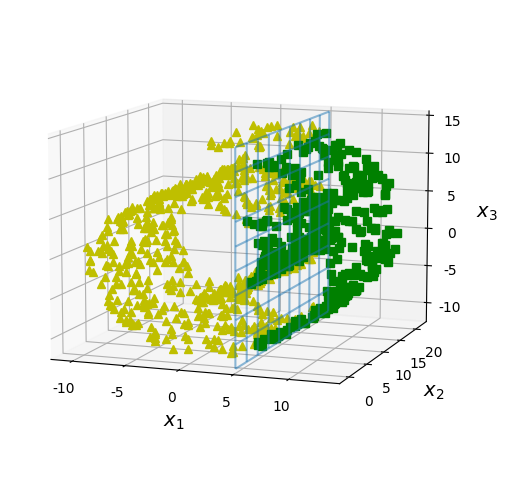

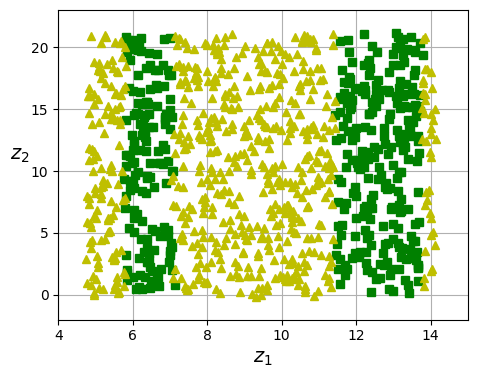

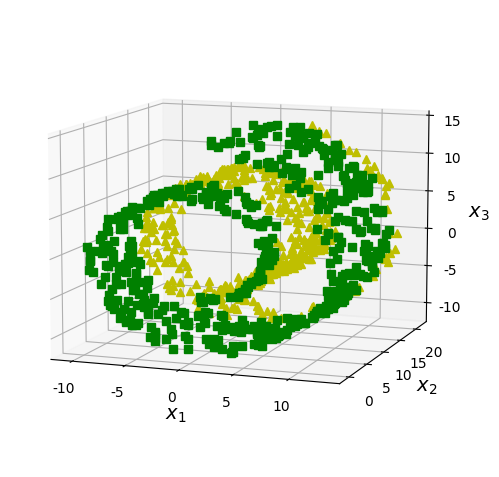

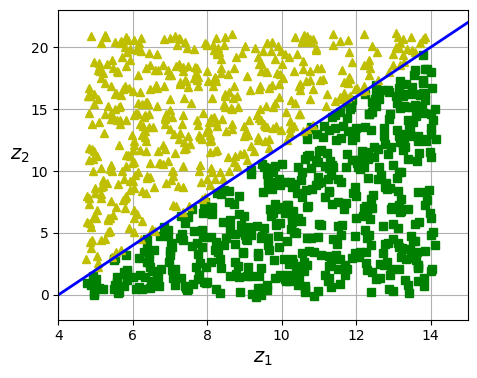

In [10]:
axes = [-11.5, 14, -2, 23, -12, 15]
x2s = np.linspace(axes[2], axes[3], 10)
x3s = np.linspace(axes[4], axes[5], 10)
x2, x3 = np.meshgrid(x2s, x3s)

positive_class = X_swiss[:, 0] > 5
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot_wireframe(5, x2, x3, alpha=0.5)
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
set_xyz_axes(ax, axes)
save_fig("manifold_decision_boundary_plot1")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
save_fig("manifold_decision_boundary_plot2")
plt.show()

positive_class = 2 * (t[:] - 4) > X_swiss[:, 1]
X_pos = X_swiss[positive_class]
X_neg = X_swiss[~positive_class]

fig = plt.figure(figsize=(6, 5))
ax = plt.subplot(1, 1, 1, projection='3d')
ax.view_init(10, -70)
ax.plot(X_neg[:, 0], X_neg[:, 1], X_neg[:, 2], "y^")
ax.plot(X_pos[:, 0], X_pos[:, 1], X_pos[:, 2], "gs")
ax.xaxis.set_rotate_label(False)
ax.yaxis.set_rotate_label(False)
ax.zaxis.set_rotate_label(False)
ax.set_xlabel("$x_1$", rotation=0)
ax.set_ylabel("$x_2$", rotation=0)
ax.set_zlabel("$x_3$", rotation=0)
ax.set_xlim(axes[0:2])
ax.set_ylim(axes[2:4])
ax.set_zlim(axes[4:6])
save_fig("manifold_decision_boundary_plot3")
plt.show()

fig = plt.figure(figsize=(5, 4))
ax = plt.subplot(1, 1, 1)
ax.plot(t[positive_class], X_swiss[positive_class, 1], "gs")
ax.plot(t[~positive_class], X_swiss[~positive_class, 1], "y^")
ax.plot([4, 15], [0, 22], "b-", linewidth=2)
ax.axis([4, 15, axes[2], axes[3]])
ax.set_xlabel("$z_1$")
ax.set_ylabel("$z_2$", rotation=0, labelpad=8)
ax.grid(True)
save_fig("manifold_decision_boundary_plot4")
plt.show()

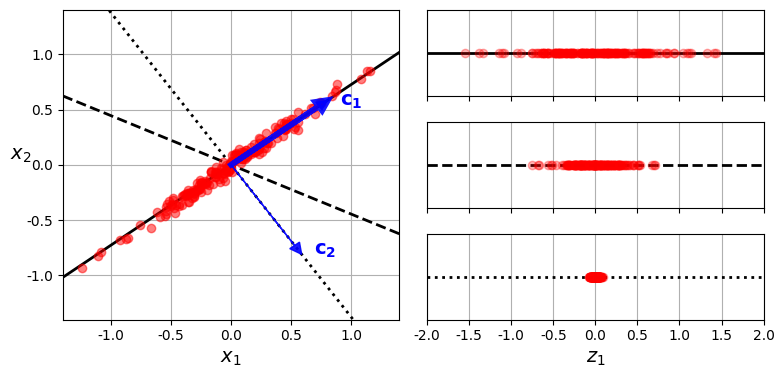

In [11]:

angle = np.pi / 5
stretch = 5
m = 200

np.random.seed(3)
X_line = np.random.randn(m, 2) / 10
X_line = X_line @ np.array([[stretch, 0], [0, 1]])  # 스트레치
X_line = X_line @ [[np.cos(angle), np.sin(angle)],
                   [np.sin(angle), np.cos(angle)]]  # 회전

u1 = np.array([np.cos(angle), np.sin(angle)])
u2 = np.array([np.cos(angle - 2 * np.pi / 6), np.sin(angle - 2 * np.pi / 6)])
u3 = np.array([np.cos(angle - np.pi / 2), np.sin(angle - np.pi / 2)])

X_proj1 = X_line @ u1.reshape(-1, 1)
X_proj2 = X_line @ u2.reshape(-1, 1)
X_proj3 = X_line @ u3.reshape(-1, 1)

plt.figure(figsize=(8, 4))
plt.subplot2grid((3, 2), (0, 0), rowspan=3)
plt.plot([-1.4, 1.4], [-1.4 * u1[1] / u1[0], 1.4 * u1[1] / u1[0]], "k-",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u2[1] / u2[0], 1.4 * u2[1] / u2[0]], "k--",
         linewidth=2)
plt.plot([-1.4, 1.4], [-1.4 * u3[1] / u3[0], 1.4 * u3[1] / u3[0]], "k:",
         linewidth=2)
plt.plot(X_line[:, 0], X_line[:, 1], "ro", alpha=0.5)
plt.arrow(0, 0, u1[0], u1[1], head_width=0.1, linewidth=4, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.arrow(0, 0, u3[0], u3[1], head_width=0.1, linewidth=1, alpha=0.9,
          length_includes_head=True, head_length=0.1, fc="b", ec="b", zorder=10)
plt.text(u1[0] + 0.1, u1[1] - 0.05, r"$\mathbf{c_1}$", color="blue")
plt.text(u3[0] + 0.1, u3[1], r"$\mathbf{c_2}$", color="blue")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$", rotation=0)
plt.axis([-1.4, 1.4, -1.4, 1.4])
plt.grid()

plt.subplot2grid((3, 2), (0, 1))
plt.plot([-2, 2], [0, 0], "k-", linewidth=2)
plt.plot(X_proj1[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (1, 1))
plt.plot([-2, 2], [0, 0], "k--", linewidth=2)
plt.plot(X_proj2[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.gca().get_xaxis().set_ticklabels([])
plt.axis([-2, 2, -1, 1])
plt.grid()

plt.subplot2grid((3, 2), (2, 1))
plt.plot([-2, 2], [0, 0], "k:", linewidth=2)
plt.plot(X_proj3[:, 0], np.zeros(m), "ro", alpha=0.3)
plt.gca().get_yaxis().set_ticks([])
plt.axis([-2, 2, -1, 1])
plt.xlabel("$z_1$")
plt.grid()

save_fig("pca_best_projection_plot")
plt.show()

## Principal Components

In [12]:
import numpy as np

# X = [...]  # 이 노트북의 앞부분에서 생성한 작은 3D 데이터셋
X_centered = X - X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [13]:
# 추가 코드 - s에서 Σ를 구성하는 방법을 보여줍니다.
m, n = X.shape
Σ = np.zeros_like(X_centered)
Σ[:n, :n] = np.diag(s)
assert np.allclose(X_centered, U @ Σ @ Vt)

### d차원으로 투영하기

In [14]:
W2 = Vt[:2].T
X2D = X_centered @ W2

In [15]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [16]:
# 설명된 분산의 비율
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

In [17]:
1 - pca.explained_variance_ratio_.sum()  # 추가 코드

0.09028309326742046

## 적절한 차원 수 선택하기

In [18]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1  # d = 154

In [19]:
d

154

In [20]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [21]:
pca.n_components_

154

In [22]:

pca.explained_variance_ratio_.sum()

0.9501960192613031

c:\Users\HeawonJeong\.conda\envs\handson\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Glyph 52264 (\N{HANGUL SYLLABLE CA}) missing from current font.
  if __name__ == "__main__":
c:\Users\HeawonJeong\.conda\envs\handson\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Glyph 50896 (\N{HANGUL SYLLABLE WEON}) missing from current font.
  if __name__ == "__main__":
c:\Users\HeawonJeong\.conda\envs\handson\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  if __name__ == "__main__":
c:\Users\HeawonJeong\.conda\envs\handson\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Glyph 49444 (\N{HANGUL SYLLABLE SEOL}) missing from current font.
  if __name__ == "__main__":
c:\Users\HeawonJeong\.conda\envs\handson\lib\site-packages\ipykernel_launcher.py:9: UserWarning: Glyph 47749 (\N{HANGUL SYLLABLE MYEONG}) missing from current font.
  if __name__ == "__main__":
c:\Users\HeawonJeong\.conda\envs\handson\l

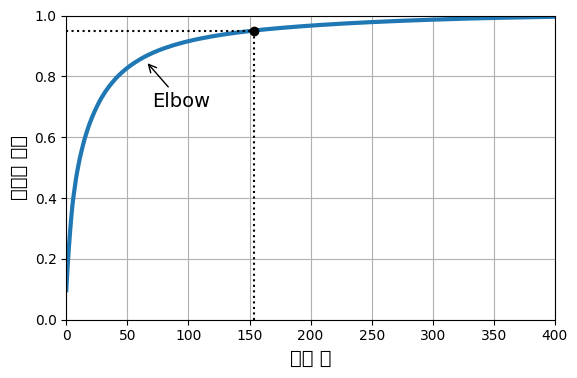

In [23]:
plt.figure(figsize=(6, 4))
plt.plot(cumsum, linewidth=3)
plt.axis([0, 400, 0, 1])
plt.xlabel("차원 수")
plt.ylabel("설명된 분산")
plt.plot([d, d], [0, 0.95], "k:")
plt.plot([0, d], [0.95, 0.95], "k:")
plt.plot(d, 0.95, "ko")
plt.annotate("Elbow", xy=(65, 0.85), xytext=(70, 0.7),
             arrowprops=dict(arrowstyle="->"))
plt.grid(True)
save_fig("explained_variance_plot")
plt.show()

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

clf = make_pipeline(PCA(random_state=42),
                    RandomForestClassifier(random_state=42))
param_distrib = {
    "pca__n_components": np.arange(10, 80),
    "randomforestclassifier__n_estimators": np.arange(50, 500)
}
rnd_search = RandomizedSearchCV(clf, param_distrib, n_iter=10, cv=3,
                                random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       6...
       414, 415, 416, 417, 418, 419, 420, 421, 422, 423, 424, 425, 426,
       427, 428, 429, 430, 431, 432, 433, 434, 435, 436, 437, 438, 439,
       440, 441, 442, 443, 444, 445, 446, 447, 448, 449, 450, 451, 452,
       453, 454, 455, 456, 457, 458, 459, 460, 461, 462, 463, 464, 465,
       466, 467, 468, 469, 470, 471, 472, 473, 474, 475, 476, 477, 478,
       479, 480, 481, 482, 483, 484, 485, 486, 487, 488, 489, 490, 491,
       

In [25]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 465, 'pca__n_components': 23}


In [26]:
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

clf = make_pipeline(PCA(random_state=42), SGDClassifier())
param_grid = {"pca__n_components": np.arange(10, 80)}
grid_search = GridSearchCV(clf, param_grid, cv=3)
grid_search.fit(X_train[:1000], y_train[:1000])

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                       ('sgdclassifier', SGDClassifier())]),
             param_grid={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79])})

In [27]:
grid_search.best_params_

{'pca__n_components': 67}

### 압축을 위한 PCA

In [28]:

pca = PCA(0.95)
X_reduced = pca.fit_transform(X_train, y_train)

In [29]:
X_recovered = pca.inverse_transform(X_reduced)

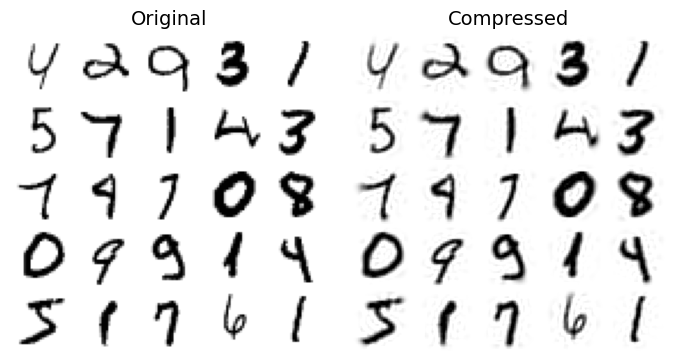

In [30]:
# extra code – this cell generates and saves Figure 8–9

plt.figure(figsize=(7, 4))
for idx, X in enumerate((X_train[::2100], X_recovered[::2100])):
    plt.subplot(1, 2, idx + 1)
    plt.title(["Original", "Compressed"][idx])
    for row in range(5):
        for col in range(5):
            plt.imshow(X[row * 5 + col].reshape(28, 28), cmap="binary",
                       vmin=0, vmax=255, extent=(row, row + 1, col, col + 1))
            plt.axis([0, 5, 0, 5])
            plt.axis("off")

save_fig("mnist_compression_plot")

In [31]:
# 랜덤 PCA

rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [32]:
# 점진적 PCA

from sklearn.decomposition import IncrementalPCA

n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [33]:
filename = "my_mnist.mmap"
X_mmap = np.memmap(filename, dtype='float32', mode='write', shape=X_train.shape)
X_mmap[:] = X_train  # 대신 루프를 사용하여 데이터를 청크 단위로 저장할 수 있습니다.
X_mmap.flush()

In [34]:
X_mmap = np.memmap(filename, dtype="float32", mode="readonly").reshape(-1, 784)
batch_size = X_mmap.shape[0] // n_batches
inc_pca = IncrementalPCA(n_components=154, batch_size=batch_size)
inc_pca.fit(X_mmap)

IncrementalPCA(batch_size=600, n_components=154)

## 랜덤 투영

In [35]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

m, ε = 5_000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps=ε)
d

7300

In [36]:
d = int(4 * np.log(m) / (ε ** 2 / 2 - ε ** 3 / 3))
d

7300

In [37]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)  # 표준 편차 = 분산의 제곱근

X = np.random.randn(m, n)  # 가짜 데이터셋 생성
X_reduced = X @ P.T

In [38]:
from sklearn.random_projection import GaussianRandomProjection

gaussian_rnd_proj = GaussianRandomProjection(eps=ε, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)  # 위와 동일한 결과

In [39]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

In [40]:
from sklearn.random_projection import SparseRandomProjection

print("GaussianRandomProjection fit")
%timeit GaussianRandomProjection(random_state=42).fit(X)
print("SparseRandomProjection fit")
%timeit SparseRandomProjection(random_state=42).fit(X)

gaussian_rnd_proj = GaussianRandomProjection(random_state=42).fit(X)
sparse_rnd_proj = SparseRandomProjection(random_state=42).fit(X)
print("GaussianRandomProjection transform")
%timeit gaussian_rnd_proj.transform(X)
print("SparseRandomProjection transform")
%timeit sparse_rnd_proj.transform(X)

GaussianRandomProjection fit
1.9 s ± 65.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection fit
1.25 s ± 29 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
GaussianRandomProjection transform
9.54 s ± 180 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
SparseRandomProjection transform
3.68 s ± 24.3 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


## LLE

In [41]:

from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)

c:\Users\HeawonJeong\.conda\envs\handson\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 47484 (\N{HANGUL SYLLABLE REUL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\HeawonJeong\.conda\envs\handson\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\HeawonJeong\.conda\envs\handson\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50857 (\N{HANGUL SYLLABLE YONG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\HeawonJeong\.conda\envs\handson\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 54616 (\N{HANGUL SYLLABLE HA}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\HeawonJeong\.conda\envs\handson\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: Glyph 50668 (\N{HANGUL SYLLABLE YEO}) missing from c

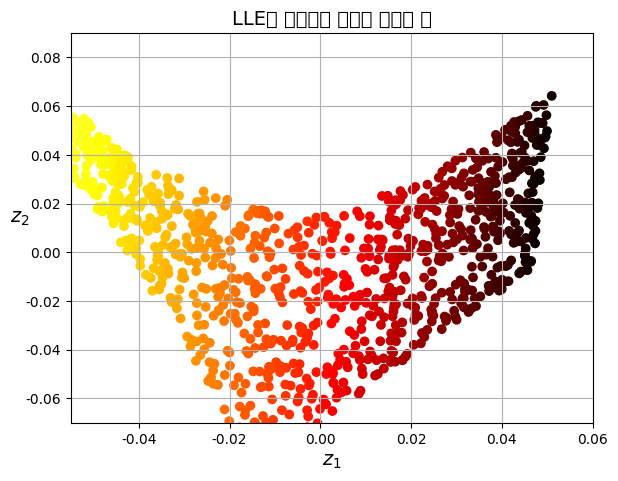

In [42]:
plt.scatter(X_unrolled[:, 0], X_unrolled[:, 1],
            c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$z_2$", rotation=0)
plt.axis([-0.055, 0.060, -0.070, 0.090])
plt.grid(True)

save_fig("lle_unrolling_plot")
plt.title("LLE를 사용하여 펼쳐진 스위스 롤")
plt.show()

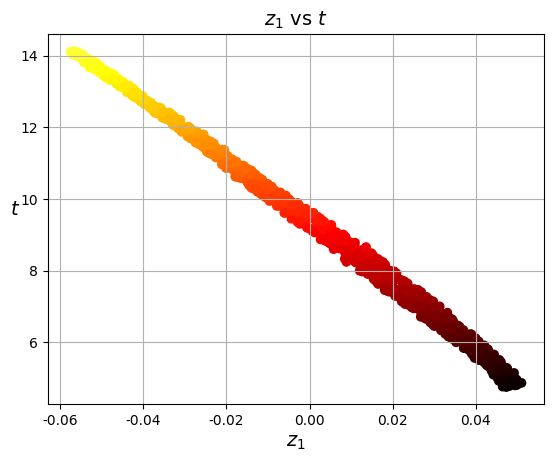

In [43]:
plt.title("$z_1$ vs $t$")
plt.scatter(X_unrolled[:, 0], t, c=t, cmap=darker_hot)
plt.xlabel("$z_1$")
plt.ylabel("$t$", rotation=0)
plt.grid(True)
plt.show()

In [44]:
from sklearn.manifold import MDS

mds = MDS(n_components=2, random_state=42)
X_reduced_mds = mds.fit_transform(X_swiss)

In [45]:

from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, init="random", learning_rate="auto",
            random_state=42)
X_reduced_tsne = tsne.fit_transform(X_swiss)

In [46]:
titles = ["MDS", "Isomap", "t-SNE"]

plt.figure(figsize=(11, 4))

for subplot, title, X_reduced in zip((131, 132, 133), titles,
                                     (X_reduced_mds, X_reduced_isomap, X_reduced_tsne)):
    plt.subplot(subplot)
    plt.title(title)
    plt.scatter(X_reduced[:, 0], X_reduced[:, 1], c=t, cmap=darker_hot)
    plt.xlabel("$z_1$")
    if subplot == 131:
        plt.ylabel("$z_2$", rotation=0)
    plt.grid(True)

save_fig("other_dim_reduction_plot")
plt.show()

NameError: name 'X_reduced_isomap' is not defined

<Figure size 1100x400 with 0 Axes>